## Excess Risk Decomposition

Recall that: <br>
Approximation Error for $\mathcal{H}$ = $R(f^*_{\mathcal{H}}) - R(f^*) $ <br>
Estimation Error of $\ \hat{f}_\mathcal{H}$ = $R(\hat{f}_{\mathcal{H}}) - R(f_{\mathcal{H}})$ <br>
Excess Risk of f = $R(f) - R(f^*)$

### Exercise:
1. From the values we calculated above, what is the approximation error for linear hypothesis space? Is approximation error a random variable? 
2. What is the estimation error of $\ \hat{f}_\mathcal{H}$? Is estimation error a random variable? 
3. What is the excess risk of  $\ \hat{f}_\mathcal{H}$? Is this a random variable? 

#### Answers:

1. Approximation Error is not random. 
2. Estimation Error is random. 
3. Excess risk of $\ \hat{f}_\mathcal{H}$ is random.

## Data Generating Process and Utility Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn import linear_model
from scipy.stats import norm
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
mu_a = 1;
sigma_a = 1;

mu_b = 2;
sigma_b = 1; 

mu_c = 3;
sigma_c = 1;

mu_x = 0;
sigma_x = 1;

assert( (mu_x == 0) and (sigma_x == 1))

In [3]:
def plot_prediction_function(f_list = None, label_list = None, data = None, alpha = 0.9, include_data_x = False,
                            x_label=None, y_label=None):
    """
    Util function that visualizes a dataset
    """
    plt.figure(figsize=(20,10))
    
    if data is not None:
        x_min, x_max = np.min(data[:, 0]), np.max(data[:, 0])
    else:
        x_min, x_max = -5.0, 5.0;
        
    if ( (f_list is not None) and (label_list is not None) ):
        x_array = np.arange(x_min, x_max, 0.1);
        if include_data_x:
            x_array = np.concatenate([x_array, data[:, 0], data[:, 0]+0.001, data[:, 0]-0.001])
            x_array = np.sort(x_array)


        for f, label in zip(f_list, label_list):
            f_y = f(x_array);
            plt.plot(x_array, f_y, label=label);
    
    if data is not None:
        plt.scatter(data[:, 0], data[:, 1], alpha = alpha )
        
    if label_list is not None:
        plt.legend()
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    plt.show()

In [4]:
## assumes g is a polynomial. Takes in a coeff list, where coeff_list[i] is the coefficient of x^i and x to evaluate it at
def template_g(coeff_list, x):
    ans = 0;
    for i, coeff in enumerate(coeff_list):
        ans += coeff * (x**i)
    return ans

### generates one sample function g
def sample_g():
    a = np.random.randn() * sigma_a + mu_a;
    b = np.random.randn() * sigma_b + mu_b;
    c = np.random.randn() * sigma_c + mu_c;
    
    return partial(template_g, [c, b, a] )
    
## give one (x,y) sample
def get_one_x_y_sample():
    x = np.random.randn()*sigma_x + mu_x;
    g = sample_g()
    return x, g(x)

## gives a matrix with first column x and second column y
def generate_n_samples(n = 1000):
    """
    Function that generates multiple samples
    @return: a (n,2) numpy matrix
    """
    matrix = np.zeros([n, 2]);
    for i in range(n):
        matrix[i] = get_one_x_y_sample();
    return matrix

## use get_one_x_y_sample()
def estimate_risk(f, n_try = int(1e5) ):
    sum = 0;
    for i in range(n_try):
        x, y = get_one_x_y_sample()
        sum += (f(x) - y)**2
    return sum/n_try

def linear_function_risk(alpha, beta):
    return 3*(sigma_a**2 + mu_a**2) + sigma_b**2 + (mu_b-alpha)**2 + 2*(mu_c - beta)*mu_a + sigma_c**2 + (mu_c - beta)**2; 

def empirical_risk(f, sample_matrix):
    fy_array = f(sample_matrix[:, 0]);
    risk = np.mean((fy_array - sample_matrix[:, 1]) ** 2)
    return risk

In [5]:
### Estimating Risk
linear_f_star = partial(template_g, [mu_a + mu_c, mu_b]);
mc_linear_f_star_risk = estimate_risk( linear_f_star) 
print('MC Risk: ', mc_linear_f_star_risk)

linear_f_star_risk = linear_function_risk(mu_b, mu_a + mu_c)
print('Risk :' , linear_f_star_risk)

bayes_risk = sigma_a**2 * 3  + sigma_b**2 * ( sigma_x**2 + mu_x**2) + sigma_c**2;
print('Bayes Risk :' ,bayes_risk)

MC Risk:  7.061878639898193
Risk : 7
Bayes Risk : 5


### Estimation Error and Excess risk of $\hat{f}_\mathcal{H}$

In [6]:
data = generate_n_samples(n = 100);

In [7]:
def estimation_error_and_excess_risk(data, risk_fh, risk_f_star):
    reg = linear_model.LinearRegression(fit_intercept=True).fit(data[:, 0:1], data[:, 1]);
    linear_f_hat_risk = linear_function_risk(reg.coef_[0], reg.intercept_)
    
    return linear_f_hat_risk - risk_fh, linear_f_hat_risk - risk_f_star

In [8]:
n_try = 1000;
estimation_error_array = np.zeros(n_try);
excess_risk_array = np.zeros(n_try)
for i in range(n_try):
    estimation_error_array[i], excess_risk_array[i] = estimation_error_and_excess_risk( generate_n_samples(n = 100), linear_f_star_risk, bayes_risk)

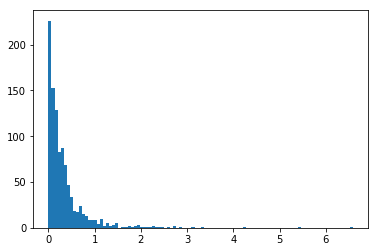

In [9]:
_ = plt.hist(estimation_error_array, bins = 100)

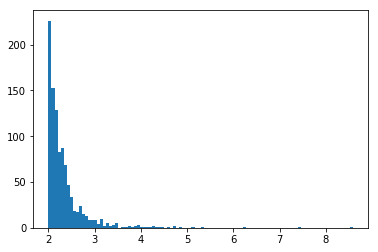

In [10]:
_ = plt.hist(excess_risk_array, bins = 100)

### Optimization Error

Since we were optimizing for L2 loss over a linear hypothesis space, we found the best possible $\hat{f}_\mathcal{H}$ (upto numerical error) using the closed form expression for linear regression. What if we use SGD instead to find $f$ and stop iterations prematurely?

In [11]:
reg_sgd = linear_model.SGDRegressor(max_iter=3, 
                                    fit_intercept = True, 
                                    penalty = 'none', #No Regularization
                                    tol = None)

In [12]:
reg_sgd.fit(data[:, 0:1], data[:, 1])

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=3,
       n_iter=None, n_iter_no_change=5, penalty='none', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [13]:
reg_sgd.intercept_, reg_sgd.coef_

(array([2.44715005]), array([1.17229068]))

In [14]:
linear_f_tilde = partial(template_g, [reg_sgd.intercept_[0], reg_sgd.coef_[0]])

In [15]:
reg = linear_model.LinearRegression(fit_intercept=True).fit(data[:, 0:1], data[:, 1])
linear_f_hat = partial(template_g, [reg.intercept_, reg.coef_[0]])

In [16]:
f_star = partial(template_g, [mu_c, mu_b, mu_a] )

In [17]:
linear_f_tilde_risk = linear_function_risk(reg_sgd.coef_[0], reg_sgd.intercept_[0])
print('Risk :' , linear_f_tilde_risk)
mc_linear_f_tilde_risk = estimate_risk( linear_f_tilde ) 
print('MC Risk: ', linear_f_tilde_risk)
linear_f_tilde_empirical_risk = empirical_risk(linear_f_tilde, data)
print('Empirical Risk: ', linear_f_tilde_empirical_risk)

Risk : 10.096445683564331
MC Risk:  10.096445683564331
Empirical Risk:  7.64722440829373


Let's visualize $\ \ f^*_\mathcal{H}$ on the dataset

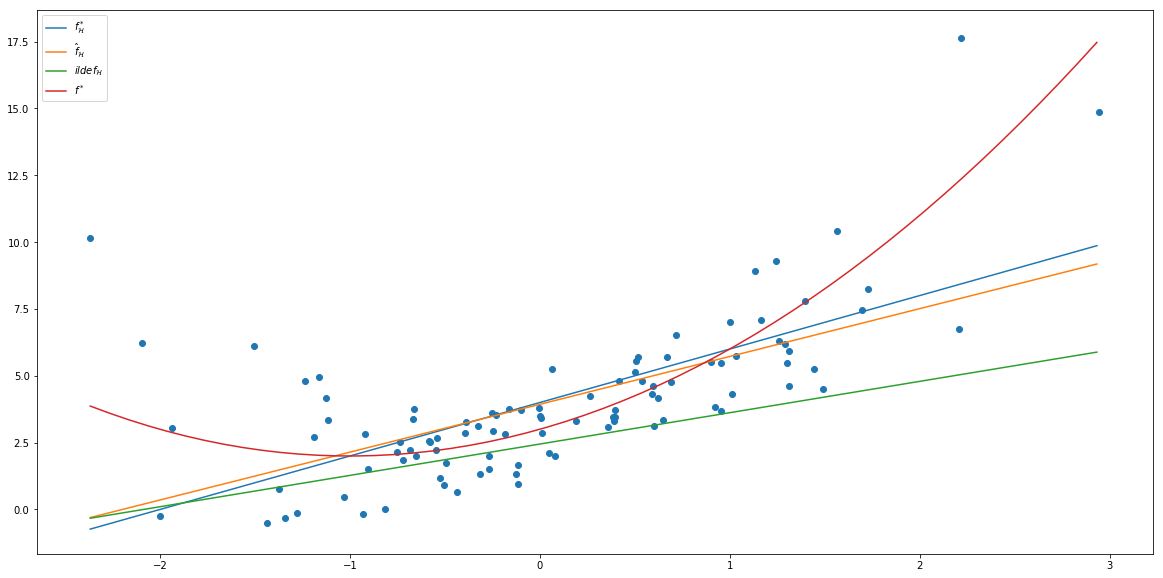

In [18]:
plot_prediction_function([linear_f_star, linear_f_hat, linear_f_tilde, f_star], 
                         ['$f^*_\mathcal{H}$', '$\hat{f}_\mathcal{H}$', '$\tilde{f_\mathcal{H}}$', '$f^*$'], 
                         data, alpha = 1)

### Exercise:
What is the optimization error? How do you expect it to change with the number of iterations of gradient descent?

Answer: As number if iterations increase, optimization error will reduce. 